# Projet : Classifier le modèle de voiture. Avec visualisation des poids mis en jeu afin de déterminer les features extraites par le réseau de neurones.

# Packages

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
from os import listdir, mkdir, rename
from os.path import isfile, join
from PIL import Image
import random as rnd
import torch
import torchvision
from torchvision import transforms
import torchvision.models as models
from torch import nn
from torch.utils.data import ConcatDataset, random_split, DataLoader
import numpy as np
from zipfile import ZipFile
from sklearn.metrics import accuracy_score
import requests
import io
import tempfile
import matplotlib.pyplot as plt

# Ajout de la librairie deeplib (https://github.com/ulaval-damas/glo4030-labs/tree/master/deeplib)
# import sys
# sys.path
# sys.path.append('/content/gdrive/My Drive/python_packages/')

# from deeplib.training import train

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Constantes

In [ ]:
folders = False
dataPath = '/content/data_car'
zipPath = '/content/gdrive/My Drive/datas/data_car.zip'
weightFile = '/content/gdrive/My Drive/datas/weight_classif_voiture.pt'
rootPath = '/content/'
batchSize = 16
usePretrained = True
trainModel = False
testModel = False

maxWidth = 720
maxHeight = 320

colorMap = 'jet'

# Dézippage pour gagner du temps de traitement

In [ ]:
zip_ref = ZipFile(zipPath, "r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
classes = os.listdir(dataPath)
classes.sort()
idx_to_class = {i: classes[i] for i in range(len(classes))}

# Fonctions

## create_folders

In [ ]:
def create_folders(DATA_PATH):
    # Chargement des images
    all_car_files = [f for f in listdir(DATA_PATH) if isfile(join(DATA_PATH, f))]
    print(f"Nombre total d'images de voitures : {len(all_car_files)}")

    # Pour afficher une image aléatoirement
    # im = Image.open(join(DATA_PATH, all_car_files[rnd.randint(0, len(all_car_files))]))
    # im.show()

    new_dir_paths = []
    associations = {}
    def extract_name_model(elem):
        return elem.split('_')[:2], elem
    file_name = list(map(extract_name_model, all_car_files))
    car_brands = set([elem[0][0] for elem in file_name])
    # car_models = set([elem[0][1] for elem in file_name])
    for br in car_brands:
        associations[br] = {}
        associations[br]['models'] = []
        associations[br]['path'] = join(DATA_PATH, br)
        mkdir(join(DATA_PATH, br))
    for elem in file_name:
        if mod not in associations[elem[0][0]]['models']:
            associations[elem[0][0]]['models'].append(elem[0][1])

    # Création des dirs modèles
    for key in associations.keys():
        for mod in associations[key]['models']:
            mkdir(join(associations[key]['path'], mod))

    # Déplacement des fichiers dans leur sous-répertoire
    for elem in file_name:
        rename(join(DATA_PATH, elem[1]) ,join(DATA_PATH, elem[0][0], elem[0][1], elem[1]))

if folders:
    create_folders(dataPath)

## training

In [ ]:
def training(model, train_dataloader, valid_dataloader=None, epoch=5, learning_rate=0.1, use_gpu=False, weight_file=None):
  
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  
  train_accu = []
  train_losses = []
  
  if valid_dataloader:
    val_accu = []
    val_loss = []
    
  for i in range(epoch):
    model.train()
    
    print('Starting epoch number {} on {} ...'.format(i+1, epoch))
    
    true = []
    pred = []
    train_loss = []
    len_train = len(train_dataloader)
    for ind, batch in enumerate(train_dataloader):
      print('\rBatch : {}/{}'.format(ind+1, len_train), end='')
      inputs, targets = batch
      
      # Aller le GPU, fais ton taff
      if use_gpu:
        inputs = inputs.cuda()
        targets = targets.cuda()
      
      optimizer.zero_grad()
        
      outputs = model(inputs)
      
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      
      predictions = outputs.max(dim=1)[1]
      
      train_loss.append(loss.item())
      true.extend(targets.data.cpu().numpy().tolist())
      pred.extend(predictions.data.cpu().numpy().tolist())
    
    accu_score = accuracy_score(true, pred) * 100
    loss_score = sum(train_loss) / len(train_loss)
    
    
    train_accu.append(accuracy_score(true, pred) * 100)
    train_losses.append(loss_score)

    if weight_file:
      torch.save(model.state_dict(), weight_file)
      
    if valid_dataloader:
      vaccu, vloss = validating(model, valid_dataloader, use_gpu)
      val_accu.append(vaccu)
      val_loss.append(vloss)
    else:
      print()
    
    print('\nTrain score : Accuracy = {:.2f} - Loss = {:.2f} | Validation score : Accuracy = {:.2f} - Loss = {:.2f}'.format(accu_score, loss_score, vaccu, vloss))
  
  if valid_dataloader:
    return train_accu, train_losses, val_accu, val_loss
  else:
    return train_accu, train_loss
  
  return None, None

## validating

In [ ]:
def validating(model, dataloader, use_gpu=False):
  true =[]
  pred = []
  val_loss = []
  len_valid = len(dataloader)
  ind = 0

  criterion = nn.CrossEntropyLoss()
  model.eval()

  for batch in dataloader:
    print('\rValidation Batch : {}/{}'.format(ind+1, len_valid), end='')

    inputs, targets = batch

    # On envoit les données au GPU pour le traitement
    if use_gpu:
      inputs = inputs.cuda()
      targets = targets.cuda()
    
    outputs = model(inputs)

    predictions = outputs.max(dim=1)[1]

    val_loss.append(criterion(outputs, targets).item())
    true.extend(targets.data.cpu().numpy().tolist())
    pred.extend(predictions.data.cpu().numpy().tolist())
    ind += 1
  
  accu_score = accuracy_score(true, pred) * 100
  loss_score = sum(val_loss) / len(val_loss)
  return accu_score, loss_score

## testing

In [ ]:
# Réutilisation du code de validation en soi (chut c'est un secret)
def testing(model, dataloader, use_gpu=False):
  model = model.cuda()
  true =[]
  pred = []
  test_loss = []
  len_test = len(dataloader)
  ind = 0

  criterion = nn.CrossEntropyLoss()
  model.eval()

  for batch in dataloader:
    print('\rTesting Batch : {}/{}'.format(ind+1, len_test), end='')

    inputs, targets = batch

    if use_gpu:
      inputs = inputs.cuda()
      targets = targets.cuda()
    
    outputs = model(inputs)
    predictions = outputs.max(dim=1)[1]

    test_loss.append(criterion(outputs, targets).item())
    true.extend(targets.data.cpu().numpy().tolist())
    pred.extend(predictions.data.cpu().numpy().tolist())
    ind += 1
  
  accu_score = accuracy_score(true, pred) * 100
  loss_score = sum(test_loss) / len(test_loss)
  return accu_score, loss_score

## predict

In [ ]:
def predict(model, data):
  model.eval()
  output = model(data)
  prediction = output.max(dim=1)[1]
  return prediction

## get_my_representations

In [ ]:
def get_my_representations(model, img_tensor):
  conv1 = model.conv1.forward(img_tensor)
  y = model.bn1.forward(conv1)
  y = model.relu.forward(y)
  y = model.maxpool.forward(y)
  layer1 = model.layer1.forward(y)
  layer2 = model.layer2.forward(layer1)
  layer3 = model.layer3.forward(layer2)
  layer4 = model.layer4.forward(layer3)
  return conv1.squeeze(), layer1.squeeze(), layer2.squeeze(), layer3.squeeze(), layer4.squeeze()

# Traitement

In [ ]:
# Création du dataset : Occupons nous du cas ou nous essayons de classifier les images selon leur marque directement
trans = transforms.Compose([
    transforms.Resize(size=(maxHeight, maxWidth)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])
augmented_trans = transforms.Compose([
    transforms.Resize(size=(maxHeight, maxWidth)),
    transforms.RandomRotation((0, 180)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])
base_dataset = torchvision.datasets.ImageFolder(
        root=dataPath,
        transform=trans)
trans_dataset = torchvision.datasets.ImageFolder(
    root=dataPath,
    transform=augmented_trans
)
dataset = ConcatDataset([base_dataset, trans_dataset])

# On veut 80% pour l'entrainement, 10% pour la validation et 10% pour les tests
train_length = int(0.8*len(dataset))
valid_length = int(0.1*len(dataset))
test_length = len(dataset)-train_length-valid_length
train_set, valid_set, test_set = random_split(dataset, [train_length, valid_length, test_length])

# On crée nos DataLoaders
train_loader = DataLoader(train_set, batch_size=batchSize, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=batchSize, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batchSize, shuffle=False)

In [ ]:
if usePretrained:
  model = models.resnet18(pretrained=False)
  model.fc = nn.Linear(in_features=512, out_features=len(np.unique(base_dataset.targets)))
  model.load_state_dict(torch.load(weightFile))
else:
  # On charge le ResNet18
  model = models.resnet18(pretrained=True)
  # On veut classer selon les 42 marques de voitures
  # print(model)
  model = model.cuda()

In [ ]:
# train_set[1][0]
# to_pil = torchvision.transforms.ToPILImage()
# img = to_pil(train_set[0][0])
# img.show()

# Entrainement

In [ ]:
if trainModel:
  accuTrain, lossTrain, accuValid, lossValid = training(model, train_loader, valid_loader, epoch=5, learning_rate=0.01, use_gpu=True, weight_file=weightFile)

# Tests et prédictions

Ne pas hésiter à trouver des images sur google, en créer un dataset et le passer dans le réseau. Ou split les données de test en deux jeux de données. Un pour les tests et l'autre pour retrouver les features extraites.

In [ ]:
if testModel:
  accuTest, lossTest = testing(model, test_loader, use_gpu=True)

## Téléchargement d'une image

In [ ]:
carUrl = "https://i.gaw.to/content/photos/39/12/391257_2020_Porsche_Taycan.jpg"
buffer = tempfile.SpooledTemporaryFile(max_size=1e9)
r = requests.get(carUrl, stream=True)
if r.status_code == 200:
    downloaded = 0
    filesize = int(r.headers['content-length'])
    for chunk in r.iter_content():
        downloaded += len(chunk)
        buffer.write(chunk)
    buffer.seek(0)
    img = Image.open(io.BytesIO(buffer.read()))
    img.save(os.path.join(rootPath, 'image.jpg'), quality=85)
buffer.close()

In [ ]:
# On affiche seulement l'image
img

Output hidden; open in https://colab.research.google.com to view.

## Prédiction de l'image téléchargée

In [ ]:
img = img.resize((maxWidth, maxHeight))
imgTensor = transforms.ToTensor()(img).unsqueeze(0)
idx_to_class[predict(model, imgTensor).item()]

'Porsche'

# Analyse des filtres

## Première convolution

In [ ]:
conv1, layer1, layer2, layer3, layer4 = get_my_representations(model, imgTensor)
fig, axes = plt.subplots(16, 4, figsize=(30, 30))
cnt = 0
for i in range(16):
  for j in range(4):
    convImg = transforms.ToPILImage()(conv1[cnt])
    axes[i, j].imshow(convImg, cmap=colorMap)
    cnt += 1
fig.savefig('conv1.png')

Output hidden; open in https://colab.research.google.com to view.

## Premier bloc

In [ ]:
fig, axes = plt.subplots(16, 4, figsize=(30, 30))
cnt = 0
for i in range(16):
  for j in range(4):
    convImg = transforms.ToPILImage()(layer1[cnt])
    axes[i, j].imshow(convImg, cmap=colorMap)
    cnt += 1
fig.savefig('layer1.png')

Output hidden; open in https://colab.research.google.com to view.

## Deuxième bloc

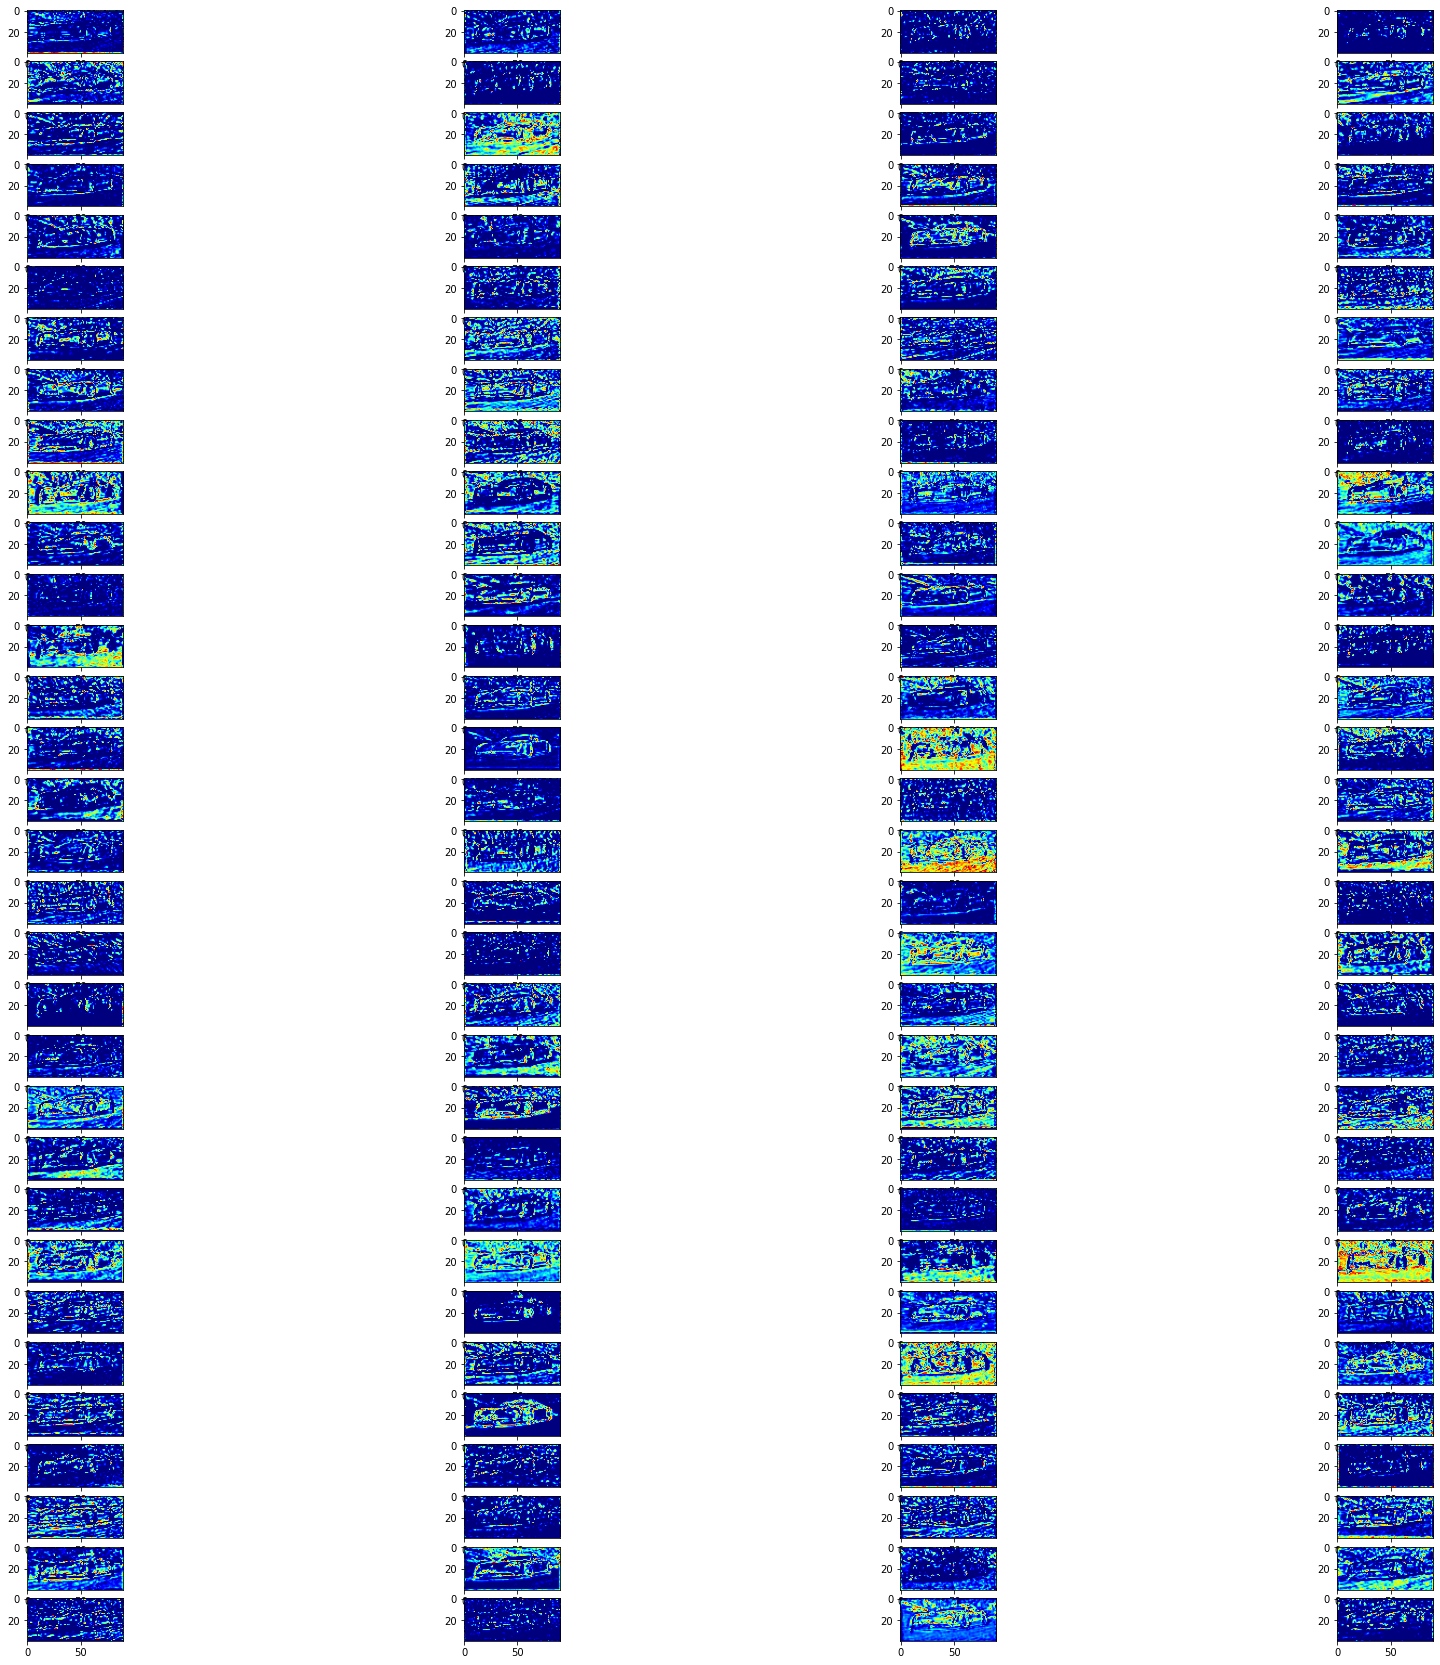

In [ ]:
fig, axes = plt.subplots(32, 4, figsize=(30, 30))
cnt = 0
for i in range(32):
  for j in range(4):
    convImg = transforms.ToPILImage()(layer2[cnt])
    axes[i, j].imshow(convImg, cmap=colorMap)
    cnt += 1
fig.savefig('layer2.png')

## Troisième bloc

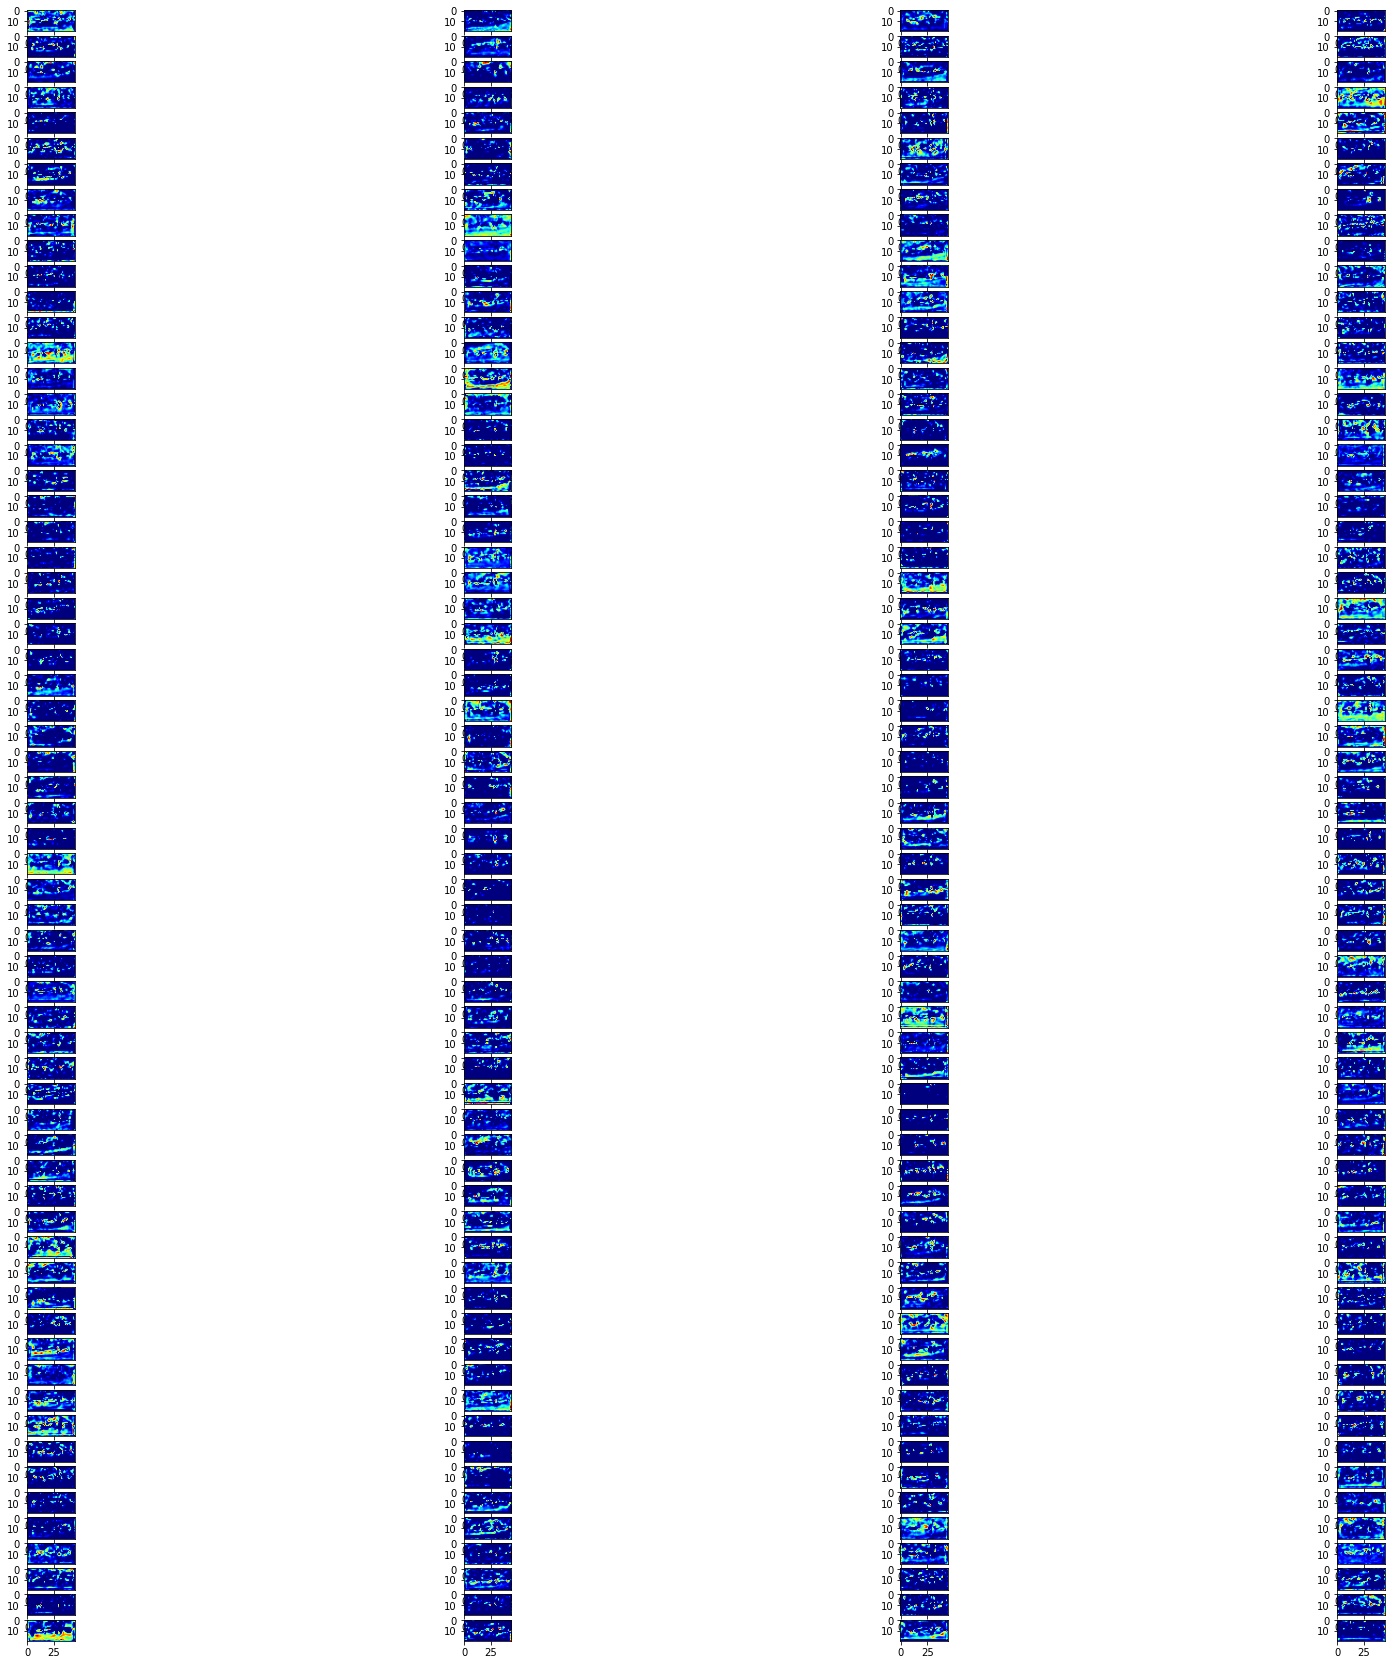

In [ ]:
fig, axes = plt.subplots(64, 4, figsize=(30, 30))
cnt = 0
for i in range(64):
  for j in range(4):
    convImg = transforms.ToPILImage()(layer3[cnt])
    axes[i, j].imshow(convImg, cmap=colorMap)
    cnt += 1
fig.savefig('layer3.png')

## Quatrième bloc

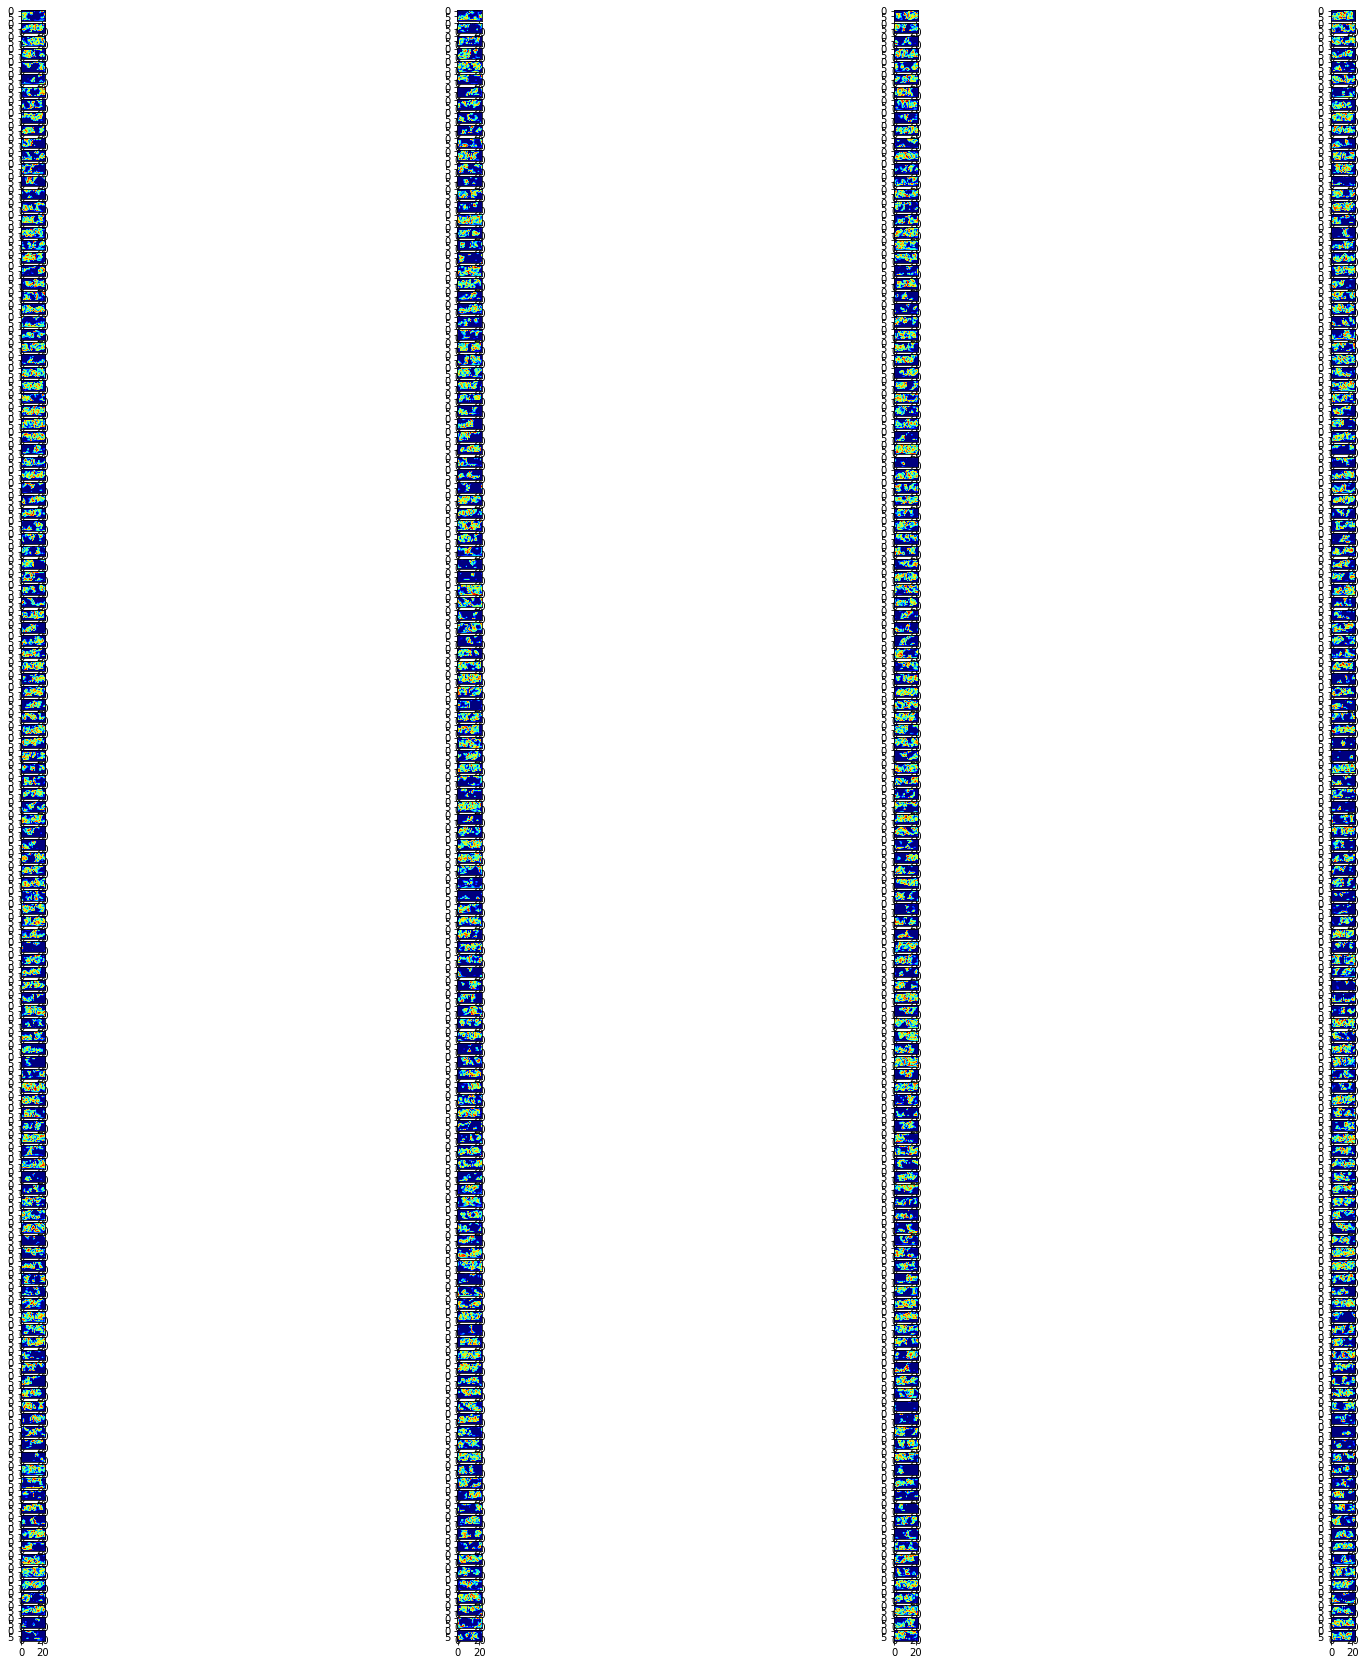

In [ ]:
fig, axes = plt.subplots(128, 4, figsize=(30, 30))
cnt = 0
for i in range(128):
  for j in range(4):
    convImg = transforms.ToPILImage()(layer4[cnt])
    axes[i, j].imshow(convImg, cmap=colorMap)
    cnt += 1
fig.savefig('layer4.png')